In [1]:
import os
import tkinter as tk
import warnings
from tkinter import filedialog

import matplotlib.pyplot as plt
import numpy as np
# import optuna
import pandas as pd
import torch
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import Dataset, random_split
from transformers import AutoFeatureExtractor, ResNetForImageClassification, TrainingArguments, Trainer

warnings.filterwarnings('ignore')

In [2]:
# Paths
data_path = 'C:/Users/nithi/Desktop/FAU/Semester-4/Master_Thesis_Federated_Learning/dataset'
csv_path = os.path.join(data_path, 'chest_image_metadata.csv')

In [3]:
# Load metadata
metadata = pd.read_csv(csv_path)

print(len(metadata))
print(metadata.shape)

metadata.head(10)

9000
(9000, 2)


,Image-ID,Label
0,00000030_001_aug_3_0.png,Atelectasis
1,00000175_001.png,Atelectasis
2,00000175_001_aug_1_0.png,Atelectasis
3,00000175_002_aug_1_0.png,Atelectasis
4,00000175_002_aug_3_0.png,Atelectasis
5,00000248_020_aug_2_0.png,Atelectasis
6,00000248_020_aug_4_0.png,Atelectasis
7,00000642_000_aug_3_0.png,Atelectasis
8,00000816_000_aug_3_0.png,Atelectasis
9,00000957_001_aug_0_0.png,Atelectasis


In [4]:
# Custom Dataset class
class PathologyDataset(Dataset):
    def __init__(self, csv_file, img_dir, processor, transform=None):
        self.metadata = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.metadata.iloc[idx, 1], self.metadata.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = classes.index(self.metadata.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        inputs = self.processor(images=image, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        return {'pixel_values': inputs['pixel_values'], 'labels': torch.tensor(label)}

In [5]:
# Define class names
classes = ['Hernia', 'Pneumonia', 'Fibrosis', 'Nodule', 'Mass', 'Consolidation', 'Effusion', 'Edema', 'Atelectasis',
           'No Finding', 'Cardiomegaly', 'Pneumothorax', 'Pleural_Thickening', 'Infiltration', 'Emphysema']

In [6]:
# Initialize processor
processor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50", force_download=False)

In [7]:
# Create dataset
dataset = PathologyDataset(csv_file=csv_path, img_dir=data_path, processor=processor)

In [8]:
# Split dataset into train, validation, and test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [9]:
# Load and modify the model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", num_labels=len(classes),
                                                     ignore_mismatched_sizes=True)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([15, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.001,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
)

In [11]:
# Define compute metrics function
def compute_metrics(p):
    pred_labels = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, pred_labels, average='weighted')
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [12]:
# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [13]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,4.682800,2.431133,0.204444,0.138460,0.204444,0.127505
2,2.343000,2.301898,0.253333,0.254915,0.253333,0.201861
3,2.066800,2.043887,0.346667,0.321211,0.346667,0.327118
4,1.515800,1.875315,0.426667,0.413501,0.426667,0.406122
5,1.109800,1.924006,0.445185,0.429812,0.445185,0.433911


TrainOutput(global_step=3940, training_loss=2.140449903459113, metrics={'train_runtime': 12241.6907, 'train_samples_per_second': 2.573, 'train_steps_per_second': 0.322, 'total_flos': 6.69673025086464e+17, 'train_loss': 2.140449903459113, 'epoch': 5.0})

In [ ]:
# # Define the objective function
# def objective(trial):
#     # Define hyperparameters
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
#     per_device_train_batch_size = trial.suggest_int('per_device_train_batch_size', 8, 32)
# 
#     # Define training arguments
#     training_args = TrainingArguments(
#         output_dir="./results",
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         learning_rate=learning_rate,
#         per_device_train_batch_size=per_device_train_batch_size,
#         per_device_eval_batch_size=16,
#         num_train_epochs=5,
#         weight_decay=0.01,
#     )
# 
#     # Create Trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_dataset,
#         eval_dataset=val_dataset,
#         compute_metrics=compute_metrics
#     )
# 
#     # Train the model
#     trainer.train()
# 
#     # Evaluate the model
#     eval_result = trainer.evaluate(eval_dataset=val_dataset)
# 
#     # Store trainer reference in the trial attributes
#     trial.set_user_attr("trainer", trainer)
# 
#     # Return the evaluation accuracy for Optuna
#     return eval_result['eval_accuracy']
# 
# # Initialize the study
# study = optuna.create_study(direction='maximize')
# 
# # Run the optimization
# study.optimize(objective, n_trials=5)
# 
# # Get the best hyperparameters
# best_hyperparameters = study.best_params
# print("Best hyperparameters:", best_hyperparameters)
# 
# # Get the best trial
# best_trial = study.best_trial
# 
# # Get the trainer for the best trial
# best_trainer = best_trial.user_attrs["trainer"]

In [14]:
 # Ensure the best_trainer is used for evaluating the test set
if trainer is not None:
    test_results = trainer.evaluate(test_dataset)
    print(test_results)
else:
    print("No valid trainer found during optimization.")

{'eval_loss': 1.883249044418335, 'eval_accuracy': 0.43925925925925924, 'eval_precision': 0.4239498111761932, 'eval_recall': 0.43925925925925924, 'eval_f1': 0.42966994867379593, 'eval_runtime': 197.7083, 'eval_samples_per_second': 6.828, 'eval_steps_per_second': 0.855, 'epoch': 5.0}


In [15]:
# Predict and evaluate on the test set
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = [example['labels'].item() for example in test_dataset]

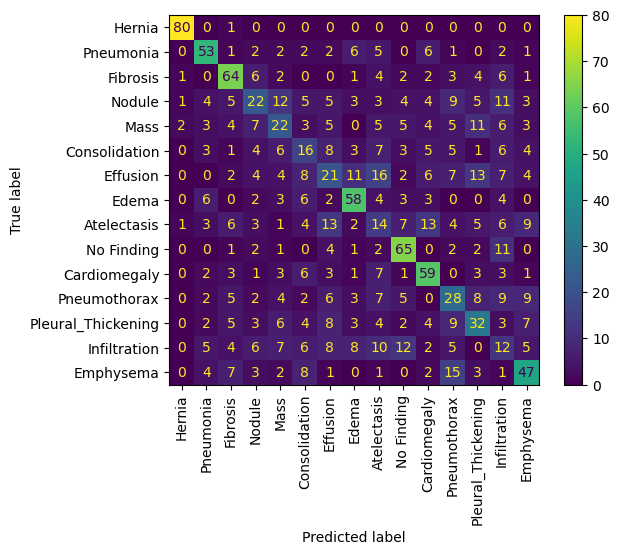

In [16]:
# Confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=classes).plot(xticks_rotation='vertical')
plt.show()

In [17]:
# Function to predict and display an image
def predict_and_display(img_path, true_label):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_label_idx = logits.argmax(-1).item()
    predicted_label = classes[predicted_label_idx]

    plt.imshow(image)
    plt.title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
    plt.axis("off")
    plt.show()

In [18]:
# Function to open a file dialog and select an image
def select_image():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("Image Files", "*.png;*.jpg;*.jpeg;*.bmp;*.gif")]
    )
    return file_path

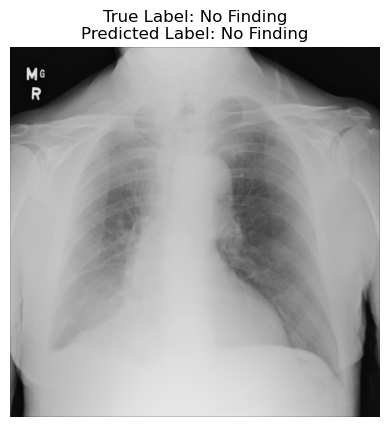

In [24]:
# Main code to select an image and predict the label
if __name__ == "__main__":
    image_path = select_image()
    if image_path:
        # Extract the image file name
        image_name = os.path.basename(image_path)

        # Find the true label from the metadata
        true_label_row = metadata[metadata.iloc[:, 0] == image_name]
        true_label = true_label_row.iloc[0, 1] if not true_label_row.empty else None

        predict_and_display(image_path, true_label)
    else:
        print("No image selected.")